In [10]:
using MriResearchTools
using Statistics
using DataFrames
using CSV

# March 2024 for the rebuttal
using StatsPlots

include("/Users/icarooliveira/Documents/ASL_7T/all_7t_ASL_functions.jl")

cnr_calc (generic function with 1 method)

In [29]:
## create folder / foldername / filenames
# main folder
foldername = "/Users/icarooliveira/Documents/ASL_7T/analysis/";

# filenames

## ====== Defining the filenames

perf_classic_fname = Dict();
perf_multix_fname = Dict();

c1_fname = Dict();
c2_fname = Dict();

for j =1:7
    # Classic
    perf_classic_fname[j,1] = (string("rsub0",j ,"_Classic_FAIR_6cm.nii"))
    perf_classic_fname[j,2] = (string("rsub0",j ,"_Classic_FAIR_9cm.nii"))
    perf_classic_fname[j,3] = (string("rsub0",j ,"_Classic_FAIR_12cm.nii"))
    
    # Multix
    perf_multix_fname[j,1] = (string("rsub0",j ,"_Multix_FAIR_6cm.nii"))
    perf_multix_fname[j,2] = (string("rsub0",j ,"_Multix_FAIR_9cm.nii"))
    perf_multix_fname[j,3] = (string("rsub0",j ,"_Multix_FAIR_12cm.nii"))

    # GM mask
    c1_fname[j] = string("Left_GM_mask.nii.gz")
    c2_fname[j] = string("Right_GM_mask.nii.gz")
    
end

## ====== Defining the folders

perf_Dir = Dict();
anat_Dir = Dict();

for j =1:7
    perf_Dir[j] = (string("s0",j ,"/perf/"))
    anat_Dir[j] = (string("s0",j, "/anat/"))
end


In [18]:
### Create Mean Perfusion
for kk = 1:7
    for k = 1:3
        savePerf(foldername, perf_Dir[kk], perf_classic_fname[kk,k])
        savePerf(foldername, perf_Dir[kk], perf_multix_fname[kk,k])
    end
end



In [20]:
### Creating ASL perf seriesASL
for kk = 1:7
    for k = 1:3
        seriesASL(foldername, perf_Dir[kk], perf_classic_fname[kk,k])
        seriesASL(foldername, perf_Dir[kk], perf_multix_fname[kk,k])
    end
end

In [39]:
## NEW FILENAMES

perf_classic_dyn_fname = Dict();
perf_multix_dyn_fname = Dict();

for j =1:7
    # Classic
    perf_classic_dyn_fname[j,1] = (string("rsub0",j ,"_Classic_reg_FAIR_6cm_dyn_perf.nii.gz"))
    perf_classic_dyn_fname[j,2] = (string("rsub0",j ,"_Classic_reg_FAIR_9cm_dyn_perf.nii.gz"))
    perf_classic_dyn_fname[j,3] = (string("rsub0",j ,"_Classic_reg_FAIR_12cm_dyn_perf.nii.gz"))
    
    # Multix
    perf_multix_dyn_fname[j,1] = (string("rsub0",j ,"_Multix_FAIR_6cm_dyn_perf.nii"))
    perf_multix_dyn_fname[j,2] = (string("rsub0",j ,"_Multix_FAIR_9cm_dyn_perf.nii"))
    perf_multix_dyn_fname[j,3] = (string("rsub0",j ,"_Multix_FAIR_12cm_dyn_perf.nii"))
    
end


In [161]:
### Create CoV Maps
cov_values_classic = Dict();
cov_values_multix = Dict();

for kk = 1:7
    for k = 1:3
        cov_values_classic[kk, k] = cov(foldername, perf_Dir[kk], perf_classic_dyn_fname[kk,k], anat_Dir[kk], c1_fname[kk], c2_fname[kk])
        cov_values_multix[kk, k] = cov(foldername, perf_Dir[kk], perf_multix_dyn_fname[kk,k], anat_Dir[kk], c1_fname[kk], c2_fname[kk])
    end
end

# C1 => LEFT
# C2 => RIGHT

In [162]:
all_classic = zeros(42);
all_multix = zeros(42);

x = 1
for i=1:7
    for j=1:3
        for l=1:2
            all_classic[x] = cov_values_classic[i,j][l]
            all_multix[x] = cov_values_multix[i,j][l]

            x = x+1
        end
    end
end

In [163]:
# DataFrames

# Classic 
classic_data = DataFrame();
classic_data.cov = all_classic;
classic_data.roi = repeat(["GM_L","GM_R"], 21);
classic_data.sub = repeat(["s01", "s02", "s03", "s04", "s05", "s06", "s07"], inner=6);
classic_data.thick = repeat([6, 9, 12], inner=2, outer =7);
classic_data.type = repeat(["2Tx"], 42);


# Multix
multix_data = DataFrame();
multix_data.cov = all_multix;
multix_data.roi = repeat(["GM_L","GM_R"], 21);
multix_data.sub = repeat(["s01", "s02", "s03", "s04", "s05", "s06", "s07"], inner=6);
multix_data.thick = repeat([6, 9, 12], inner=2, outer =7);
multix_data.type = repeat(["pTx"],42);

# Combining (merging) both datasets
all_data = vcat(classic_data, multix_data)

# saving CSV data
data_6cm = filter(:thick => n->n == (6), all_data)

CSV.write(joinpath(pwd(), "dataCoV.csv"), data_6cm)
CSV.write(joinpath(pwd(), "alldataCoV.csv"), all_data)



"/Users/icarooliveira/Documents/ASL_7T/alldataCoV.csv"

In [164]:
## analysis

using GLM
classic_L_data = filter(:roi => n->n == ("GM_L"), classic_data)
multix_L_data = filter(:roi => n->n == ("GM_L"), multix_data)

classic_R_data = filter(:roi => n->n == ("GM_R"), classic_data)
multix_R_data = filter(:roi => n->n == ("GM_R"), multix_data)

fm = @formula(cov ~ thick)
linear_L_classic = lm(fm, classic_L_data)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

cov ~ 1 + thick

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)    Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.347022      0.2718   1.28    0.2171  -0.221861     0.915906
thick        0.0526326     0.02914  1.81    0.0868  -0.00835814   0.113623
──────────────────────────────────────────────────────────────────────────

In [165]:
linear_L_multix = lm(fm, multix_L_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

cov ~ 1 + thick

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)    Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.223564    0.165852   1.35    0.1935  -0.123568    0.570696
thick        0.0424537   0.0177812  2.39    0.0275   0.00523717  0.0796701
──────────────────────────────────────────────────────────────────────────

In [166]:
linear_R_classic = lm(fm, classic_R_data)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

cov ~ 1 + thick

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.348867    0.232114   1.50    0.1493  -0.136954    0.834687
thick        0.0733708   0.0248852  2.95    0.0083   0.0212854   0.125456
─────────────────────────────────────────────────────────────────────────

In [167]:
linear_R_multix = lm(fm, multix_R_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

cov ~ 1 + thick

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     t  Pr(>|t|)     Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.266512   0.127763   2.09    0.0507  -0.000899924  0.533924
thick        0.037305   0.0136977  2.72    0.0135   0.00863545   0.0659746
──────────────────────────────────────────────────────────────────────────

In [168]:
## ====== Defining the filenames

perf_classic_fname = Dict();
perf_multix_fname = Dict();

c1_fname = Dict();
c2_fname = Dict();

for j =1:7
    # Classic
    perf_classic_fname[j,1] = (string("rsub0",j ,"_Classic_reg_FAIR_6cm_meanPerf.nii.gz"))
    perf_classic_fname[j,2] = (string("rsub0",j ,"_Classic_reg_FAIR_9cm_meanPerf.nii.gz"))
    perf_classic_fname[j,3] = (string("rsub0",j ,"_Classic_reg_FAIR_12cm_meanPerf.nii.gz"))
    
    # Multix
    perf_multix_fname[j,1] = (string("rsub0",j ,"_Multix_FAIR_6cm_meanPerf.nii"))
    perf_multix_fname[j,2] = (string("rsub0",j ,"_Multix_FAIR_9cm_meanPerf.nii"))
    perf_multix_fname[j,3] = (string("rsub0",j ,"_Multix_FAIR_12cm_meanPerf.nii"))

    # GM mask
    c1_fname[j] = string("Left_GM_mask.nii.gz")
    c2_fname[j] = string("Right_GM_mask.nii.gz")
    
end

In [169]:
## sSNR
temp_classic = zeros(7,2);
temp_multix = zeros(7,2);

for kk = 1:7
    for k = 1:2
        temp_classic[kk, :].=sSNR_perf( foldername, perf_Dir[kk], perf_classic_fname[kk,1], anat_Dir[kk], c1_fname[kk], c2_fname[kk])
        temp_multix[kk, :].=sSNR_perf(foldername, perf_Dir[kk], perf_multix_fname[kk,1], anat_Dir[kk], c1_fname[kk], c2_fname[kk])
    end
end




In [160]:
## merging all the dataset

# classic_data = DataFrame(temp_classic,:auto)
# multix_data = DataFrame(temp_multix,:auto)

# new_classic_vector = vcat(temp_classic[:,1], temp_classic[:,2]);
# new_multix_vector = vcat(temp_multix[:,1], temp_multix[:,2]);



all_data = DataFrame();
#vcat(multix_data, classic_data)

all_data.roi = repeat(["GM_L","GM_R"], inner=14);
all_data.sub = repeat(["P01","P02", "P03", "P04", "P05", "P06", "P07"], outer=4);
all_data.coil = repeat(["2Tx", "pTx"], inner=7, outer =2);
all_data.values = vcat(temp_classic[:,1],temp_multix[:,1],temp_classic[:,2],temp_multix[:,2]);

CSV.write(joinpath(pwd(), "sSNR.csv"), all_data)

"/Users/icarooliveira/Documents/ASL_7T/sSNR.csv"

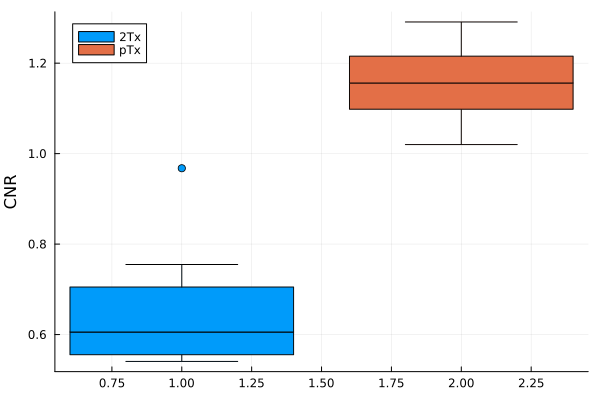

In [9]:

# March 2024 for the rebuttal
# CNR

filenames_classic = Dict("sub$(lpad(i, 2, '0'))" => "/Users/icarooliveira/Documents/ASL_7T/analysis/s$(lpad(i, 2, '0'))/perf/rsub$(lpad(i,2,'0'))_Classic_reg_FAIR_6cm_meanPerf.nii.gz" for i in 1:7);
filenames_multix = Dict("sub$(lpad(i, 2, '0'))" => "/Users/icarooliveira/Documents/ASL_7T/analysis/s$(lpad(i, 2, '0'))/perf/rsub$(lpad(i,2,'0'))_Multix_FAIR_6cm_meanPerf.nii" for i in 1:7);

filenames_gm = Dict("sub$(lpad(i, 2, '0'))" => "/Users/icarooliveira/Documents/ASL_7T/analysis/s$(lpad(i, 2, '0'))/anat/GM_bin.nii.gz" for i in 1:7);
filenames_wm = Dict("sub$(lpad(i, 2, '0'))" => "/Users/icarooliveira/Documents/ASL_7T/analysis/s$(lpad(i, 2, '0'))/anat/WM_bin.nii.gz" for i in 1:7);

sublist = ["sub01" "sub02" "sub03" "sub04" "sub05" "sub06" "sub07"];

cnr_nordic = zeros(7,2)

for i=1:7
    cnr_nordic[i,1] = cnr_calc(filenames_classic[sublist[i]], filenames_gm[sublist[i]], filenames_wm[sublist[i]]);
    cnr_nordic[i,2] = cnr_calc(filenames_multix[sublist[i]], filenames_gm[sublist[i]], filenames_wm[sublist[i]]);
end


boxplot(cnr_nordic, ylabel="CNR",label=["2Tx" "pTx"])


In [11]:
cnr_nordic

7×2 Matrix{Float64}:
 0.967635  1.24774
 0.552118  1.06696
 0.540568  1.15608
 0.60563   1.01999
 0.754791  1.12939
 0.655286  1.29099
 0.558726  1.18315